**извлечение признаков из текста на естественном языке**

классификатор текстов SnowballStemmer+TfidfVectorizer

_Евгений Борисов <esborisov@sevsu.ru>_

## библиотеки

In [1]:
import re
# import gzip
import numpy as np
import numpy.random as rng
import pandas as pd
from tqdm.notebook import tqdm

np.set_printoptions(precision=2) # вывод на печать чисел до 2 знака
pd.options.display.max_colwidth = 200 

tqdm.pandas()

In [2]:
# import numpy as np
# import pandas as pd
# import re

In [3]:
from sklearn import __version__ as SKLEARN_VERSION

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

SKLEARN_VERSION

'1.0.2'

In [4]:
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords as nltk_stopwords
# from nltk import download as nltk_download
# nltk_download('stopwords')

## тексты

In [5]:
# загружаем тексты
data = pd.read_pickle('../data/news.pkl.gz')
print('записей:',len(data))
data.sample(2)

записей: 3196


,text,tag
1322,"Видео: эстонский боевой робот расстрелял ""жигули""\n\n5 декабря 2016 в 15:42\n\nДенис Алдохин / 42.TUT.BY\n\nЭстонские вооруженные силы успешно испытали беспилотного боевого робота THeMIS ADDER, со...",tech
2134,"Нападающий ""Ростова"" Сердар Азмун назван лучшим молодым футболистом Азии в 2016 году, информирует официальный сайт ростовчан.В текущем сезоне 21-летний форвард забил за "" Ростов "" шесть голов. В с...",sport


## токенизация и очистка

In [6]:
# # собираем словарь из текстов
# def get_vocabulary(ds):
#     vcb = [ set(s) for s in ds.tolist() ]
#     return sorted(set.union(*vcb))

In [7]:
# применяет список замен pat к строке s
def replace_patterns(s,pat):
    if len(pat)<1: return s
    return  replace_patterns( re.sub(pat[0][0],pat[0][1],s), pat[1:] )

# нормализация текста
def string_normalizer(s):
    pat = [
       [r'ё','е'] # замена ё для унификации
       ,[r'</?[a-z]+>',' '] # удаляем xml
       ,[r'[^a-zа-я\- ]+',' '] # оставляем только буквы, пробел и -
       ,[r' -\w+',' '] # удаляем '-й','-тый' и т.п.
       ,[r'\w+- ',' ']
       ,[r' +',' '] # удаляем повторы пробелов
    ]
    return replace_patterns(s.lower(),pat).strip()

In [8]:
data['ctext'] = data['text'].progress_apply(string_normalizer)

  0%|          | 0/3196 [00:00<?, ?it/s]

##  Vectorizer

In [9]:
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords as nltk_stopwords

stopwords = set(nltk_stopwords.words('russian'))
stemmer = SnowballStemmer('russian')

# разрезаем стоки на слова, выкидываем stopwords, выполняем стеминг
def tokenizer_stemmer(s,stemmer=stemmer,stopwords=stopwords): 
    for w in s.split(' '):
        o = stemmer.stem(w).replace('^','')
        if len(o)<2: continue
        if o in stopwords: continue
        yield o        

In [10]:
%%time

# вариант использования токенайзера вместе с векторайзером
tf = TfidfVectorizer(
        use_idf=False, 
        norm='l2', 
        tokenizer=tokenizer_stemmer, 
        token_pattern=None
    ).fit( data['ctext'] )

CPU times: user 1min 15s, sys: 43.2 ms, total: 1min 15s
Wall time: 1min 16s


In [11]:
vcb1 = sorted(tf.vocabulary_)
print(len(vcb1))
pd.Series(vcb1).sample(30)

36354


7667     врачам-консультант
34629                   цка
26359              прочност
23018                пиксел
554               christina
2015                   mojo
827                 douglas
7846                  вчита
35844         электротехник
19254            невыполним
6726            ветлечебниц
4706                 аффлек
30557        стартап-движен
5850               бормотух
1783                  lipid
17264            машинописн
31646              терорист
14343                 кладк
5166                 бейтма
15750               кулешов
32087              требован
29881                  сола
36226                яичниц
24187                полсил
2165                     nl
11109              елисеенк
25824            прогрессир
20344            обеспокоен
5156              безуспешн
34481                 хэнкс
dtype: object

In [12]:
# pd.Series(vcb1).sample(30)

## формируем датасеты

In [13]:
%%time 

X = tf.transform( data['ctext'])
X.shape

CPU times: user 1min 13s, sys: 37.9 ms, total: 1min 13s
Wall time: 1min 13s


(3196, 36354)

In [14]:
labels = { t:i for i,t in enumerate(sorted(set(data['tag']))) }
labels

{'auto': 0,
 'culture': 1,
 'economics': 2,
 'health': 3,
 'incident': 4,
 'politics': 5,
 'realty': 6,
 'reclama': 7,
 'science': 8,
 'social': 9,
 'sport': 10,
 'tech': 11,
 'woman': 12}

In [15]:
y = data['tag'].map(labels).values
y

array([5, 1, 1, ..., 8, 5, 9])

In [16]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=326 )
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2237, 36354), (2237,), (959, 36354), (959,))

## обучаем классификатор

In [17]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss='hinge',max_iter=1000, tol=0.19)
clf.fit(X_train,y_train)

SGDClassifier(tol=0.19)

## тестируем

In [18]:
# для правильный ответов на учебном наборе
o = clf.predict(X_train)
accuracy_score(y_train,o)

0.9995529727313366

In [19]:
# для правильный ответов на тестовом наборе
o = clf.predict(X_test)
accuracy_score(y_test,o)

0.8748696558915537

In [20]:
print( classification_report(y_test,o) )

              precision    recall  f1-score   support

           0       0.95      0.89      0.92        87
           1       0.78      0.95      0.86       101
           2       0.82      0.78      0.80        76
           3       0.88      0.71      0.79        31
           4       0.90      0.93      0.91       123
           5       0.91      0.95      0.93       177
           6       0.88      0.67      0.76        21
           7       0.79      0.65      0.71        17
           8       0.87      1.00      0.93        68
           9       0.55      0.41      0.47        44
          10       0.99      0.99      0.99       118
          11       0.85      0.79      0.82        89
          12       0.83      0.71      0.77         7

    accuracy                           0.87       959
   macro avg       0.85      0.80      0.82       959
weighted avg       0.87      0.87      0.87       959



---

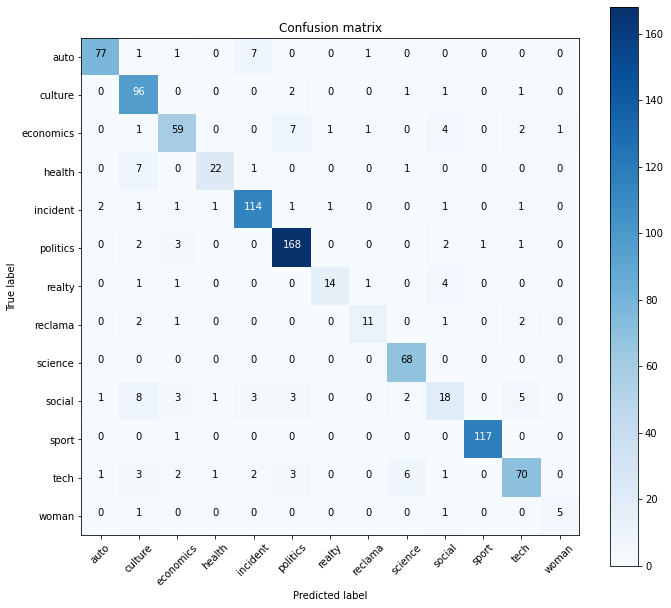

In [21]:
from matplotlib import pyplot as plt
import itertools

classes = sorted(labels.keys())
cm = confusion_matrix(y_test,o)
tick_marks = np.arange(len(classes))

plt.figure(figsize=(10,9))

plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.title('Confusion matrix')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

plt.show()

---

In [22]:
o = clf.predict(X)

In [23]:
labels_inv = { labels[k]:k for k in labels }
# labels_inv

In [24]:
for n in range(10):
    i = rng.randint(len(data))
    print('tag:',data.iloc[i,1])
    print('predict:',labels_inv[o[i]])
    print(re.sub(r'\n\s*\n',' ',data.iloc[i,0][:200])+'...')
    print('- - - - - - - - - - - - - - - - - -')
    

tag: sport
predict: sport
«Индиана» — «Шарлотт» 110:94 «Индиана Пэйсерс» на домашнем паркете обыграла «Шарлотт Хорнетс» со счетом 110:94 (25:20, 20:23, 31:30, 34:21). Наибольший вклад в успех хозяев внесли Пол Джордж и Майлз...
- - - - - - - - - - - - - - - - - -
tag: auto
predict: auto
Так Audi Q3 нового поколения предстанет как с обычным бензиновым, либо дизельным мотором. А также для китайского рынка кроссовер выйдет с гибридным двигателем.Автокомпания Audi приняла решение внедрит...
- - - - - - - - - - - - - - - - - -
tag: sport
predict: sport
Минское "Динамо" заключило контракт с защитником сборной Беларуси по хоккею 9 декабря 2016 в 17:52 SPORT.TUT.BY Защитник национальной сборной Беларуси Роман Граборенко заключил с минским «Динамо» с...
- - - - - - - - - - - - - - - - - -
tag: social
predict: social
В Минске число обращений в больницу скорой помощи с гололедными травмами выросло в 5 раз 8 декабря 2016 в 18:34 БЕЛТА В городской клинической больнице скорой медицинской помощи Минс

In [25]:
# https://habr.com/ru/post/205360/